In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

In [2]:
def fn_cubed(X):
  return (X**3).sum(axis=0)
def fn_cubed_grad(X):
  return 3*X**2

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD

# from google.colab import drive
# drive.mount('/content/drive')

# CNN MODEL FOR MNIST DATASET
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

model = define_model()
model.load_weights('mnist_cnn_weights.weights.h5')

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load the test dataset
(_, _), (testX, testY) = mnist.load_data()

# Reshape the data to have a single channel
testX = testX.reshape((testX.shape[0], 28, 28, 1))

# Normalize the pixel values to the range [0, 1]
testX = testX.astype('float32') / 255.0

# One-hot encode the labels
testY = to_categorical(testY)

# Evaluate the model
# loss, accuracy = model.evaluate(testX, testY, verbose=0)
# print(f'Test accuracy: {accuracy * 100:.2f}%')
# print(f'Test loss: {loss:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
def get_fx_fxI(f, xs, Is):
  """
  Returns arrays fx and fxI, defined as:
  fx[i]    = f(x),   where x = xs[i]
  fxI[i,j] = f(x-I), where x = xs[i], I = Is[j]
  """
  inputs = []
  for x in xs:
    inputs.append(x)
    for I in Is:
      inputs.append(x-I)
  inputs = np.array(inputs)
  outputs = f(inputs)
  fx = np.ndarray((len(xs),))
  fxI = np.ndarray((len(xs), len(Is)))
  o = 0
  for i in range(len(xs)):
    fx[i] = outputs[o]
    o += 1
    for j in range(len(Is)):
      fxI[i,j] = outputs[o]
      o += 1
  return fx, fxI

In [5]:
def explain_metrix(fx, fxI, Is, lam, N, K, tol):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  int_II = np.array([I @ I.T for I in Is]).mean(axis=0)
  ints_Idf = np.ndarray((N+1, K, 1))
  for i in range(N+1):
    ints_Idf[i] = np.array([I * (fx[i] - fxI[i,j]) for j, I in enumerate(Is)]).mean(axis=0)
  first_mat = np.linalg.inv(lam * N * np.identity(K) + int_II)

  ints_Idf = torch.tensor(ints_Idf, device=device)
  first_mat = torch.tensor(first_mat, device=device)

  phis = torch.zeros(N+1, K, 1, device=device)
  while True:
    phis_prev = phis.clone()
    for n in range(N+1):
      phis_sum = phis.sum(axis=0)
      second_mat = lam * (phis_sum - phis[n]) + ints_Idf[n]
      phis[n] = first_mat @ second_mat
    if torch.abs(phis - phis_prev).max() < tol:
      break

  return np.array(phis.cpu())

In [6]:
def explain_yeh(fx, fxI, Is, lam, N, K):
  int_II = np.array([I @ I.T for I in Is]).mean(axis=0)
  int_II_inv = np.linalg.inv(int_II)

  phis = np.zeros((N+1, K, 1))
  for i in range(N+1):
    int_Idf = np.array([I * (fx[i] - fxI[i,j]) for j, I in enumerate(Is)]).mean(axis=0)
    phis[i] = int_II_inv @ int_Idf

  return phis

In [7]:
# np.random.seed(0)

# N = 100
# M = 1000
# K = 784
# lam = 2/N
# tol = 1e-5

# x_orig = testX[0].reshape(784, 1)
# xs = [x_orig]
# for _ in range(N):
#   xs.append(x_orig + np.random.normal(size=x_orig.shape, scale=0.2))

# Is = []
# for _ in range(M):
#   Is.append(np.random.normal(size=x_orig.shape, scale=0.2))

# probs = model.predict(x_orig.reshape(1, 28, 28, 1)).flatten()
# max_class = probs.argmax()
# def fn_mnist(x):
#   x = x.reshape(-1, 28, 28, 1)
#   probs = model.predict(x)
#   return probs[:, max_class]

# fx, fxI = get_fx_fxI(fn_mnist, xs, Is)

# print(explain_metrix(fx, fxI, Is, lam, N, K, tol))
# print(explain_yeh(fx, fxI, Is, lam, N, K))

In [8]:
def visualize_infidelity(f, xs, Is, explanations):
  infidelities = []
  for x in xs:
    f_x = f(x)
    for I in Is:
      actual_change = f_x - f(x - I)
      predicted_change = I.T @ explanations  # Use the single explanation vector
      infidelity = (predicted_change - actual_change)**2
      infidelities.append(infidelity[0, 0])  # Take scalar value from 1x1 array

  # Plotting the infidelity distribution
  plt.figure(figsize=(10, 6))
  plt.hist(infidelities, bins=30, color="skyblue", edgecolor="black")
  plt.title("Infidelity of Explanation")
  plt.xlabel("Infidelity (Squared Error)")
  plt.ylabel("Frequency")
  plt.show()

  # Print average infidelity as a summary metric
  avg_infidelity = np.mean(infidelities)
  print(f"Average Infidelity: {avg_infidelity}")

In [9]:
def infidelity(fx, fxI, phi, Is):
  a = [(I.T @ phi - (fx - fxI[j]))**2 for j, I in enumerate(Is)]
  return np.array(a).mean()

def sensitivity(phis):
  phi0 = phis[0]
  return max(((phi-phi0)**2).sum() for phi in phis[1:])

In [ ]:
points = [ f"p{i}" for i in range(5) ]
N = 100
M = 1000
lam = 5e-4
tol = 1e-5

def run_explanations(x):
  np.random.seed(0)
  K = x.shape[0]

  xs = [x]
  for _ in range(N):
    xs.append(x + np.random.normal(size=x.shape, scale=0.2))

  Is = []
  for _ in range(M):
    Is.append(x - np.random.normal(size=x.shape, scale=0.01))

  probs = model.predict(x.reshape(1, 28, 28, 1)).flatten()
  max_class = probs.argmax()
  def fn_mnist(inputs):
    inputs = inputs.reshape(-1, 28, 28, 1)
    probs = model.predict(inputs)
    return probs[:, max_class]

  fx, fxI = get_fx_fxI(fn_mnist, xs, Is)

  return (explain_metrix(fx, fxI, Is, lam, N, K, tol),
          explain_yeh(fx, fxI, Is, lam, N, K),
          xs, Is, fx, fxI)


def run_T_times(T):
  xes = [testX[i].reshape(784, 1) for i in range(T)]

  ours_results = []
  yehs_results = []
  ours_results_infidelity = []
  yehs_results_infidelity = []
  ours_results_sensitivity = []
  yehs_results_sensitivity = []

  for i in range(T):
    ours, yehs, cur_xs, cur_Is, fx, fxI = run_explanations(xes[i])
    ours_results.append(ours)
    yehs_results.append(yehs)

    cur_ours_inf = infidelity(fx[0], fxI[0], ours[0], cur_Is)
    cur_yehs_inf = infidelity(fx[0], fxI[0], yehs[0], cur_Is)
    cur_ours_sens = sensitivity(ours)
    cur_yehs_sens = sensitivity(yehs)

    ours_results_infidelity.append(cur_ours_inf)
    yehs_results_infidelity.append(cur_yehs_inf)
    ours_results_sensitivity.append(cur_ours_sens)
    yehs_results_sensitivity.append(cur_yehs_sens)

    if not os.path.exists('output'):
      os.mkdir('output')
    for j in range(N):
      np.save(f'output/image_{i}_perturb_{j}', cur_xs[j].reshape(28, 28))
      np.save(f'output/ours_{i}_perturb_{j}', ours[j].reshape(28, 28))
      np.save(f'output/yehs_{i}_perturb_{j}', yehs[j].reshape(28, 28))

  return (ours_results_infidelity, yehs_results_infidelity,
          ours_results_sensitivity, yehs_results_sensitivity)

results = run_T_times(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3160/3160 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
for res in results:
  print(res)

[1.5940850060607337e-05]
[1.9176257051299806e-06]
[0.0060376823]
[6.980938896163817]


In [ ]:
!zip -r /content/output.zip /content/output

updating: content/output/ (stored 0%)
updating: content/output/yehs_0_perturb_17.npy (deflated 11%)
updating: content/output/ours_2_perturb_38.npy (deflated 7%)
updating: content/output/yehs_2_perturb_97.npy (deflated 11%)
updating: content/output/image_1_perturb_67.npy (deflated 5%)
updating: content/output/image_1_perturb_76.npy (deflated 4%)
updating: content/output/image_2_perturb_13.npy (deflated 5%)
updating: content/output/ours_1_perturb_5.npy (deflated 8%)
updating: content/output/image_0_perturb_59.npy (deflated 5%)
updating: content/output/ours_3_perturb_55.npy (deflated 8%)
updating: content/output/image_3_perturb_68.npy (deflated 5%)
updating: content/output/ours_4_perturb_76.npy (deflated 7%)
updating: content/output/yehs_2_perturb_24.npy (deflated 12%)
updating: content/output/image_2_perturb_34.npy (deflated 5%)
updating: content/output/ours_0_perturb_96.npy (deflated 7%)
updating: content/output/yehs_4_perturb_2.npy (deflated 13%)
updating: content/output/image_4_pertur

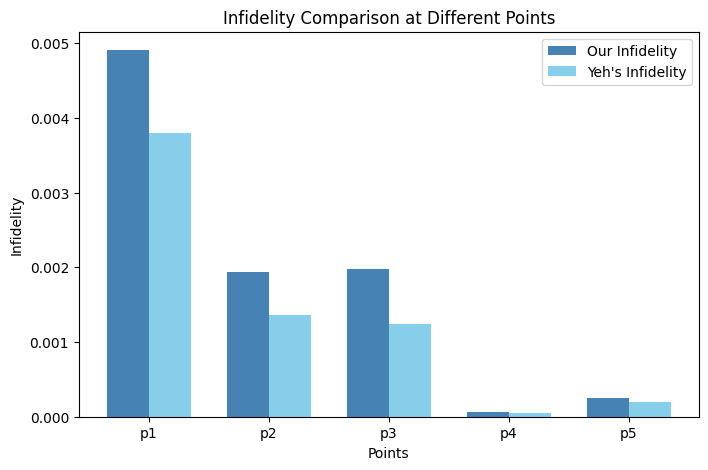

<Figure size 640x480 with 0 Axes>

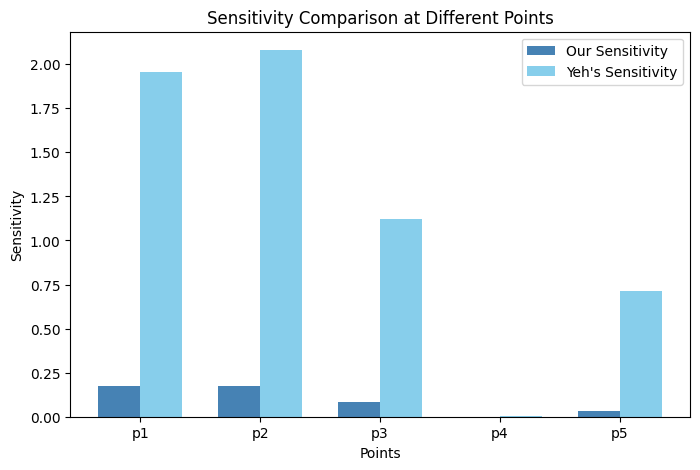

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize(metric="Infidelity", ours=results[0], yehs=results[1]):
  # Points for the x-axis
  points = ['p1', 'p2', 'p3', 'p4', 'p5']

  x = range(len(points))
  width = 0.35

  fig, ax = plt.subplots(figsize=(8, 5))
  bars1 = ax.bar(x, ours, width, label=f'Our {metric}', color="steelblue")
  bars2 = ax.bar([p + width for p in x], yehs, width, label=f"Yeh's {metric}", color="skyblue")

  # Add labels, title, and custom x-axis tick labels
  ax.set_xlabel('Points')
  ax.set_ylabel(f'{metric}')
  ax.set_title(f'{metric} Comparison at Different Points')
  ax.set_xticks([p + width / 2 for p in x])
  ax.set_xticklabels(points)
  ax.legend()

  plt.show()
  plt.savefig(f"{metric}_comparison_chart.png", dpi=300, bbox_inches="tight")
  plt.close(fig)

visualize("Infidelity", results[0], results[1])
visualize("Sensitivity", results[2], results[3])

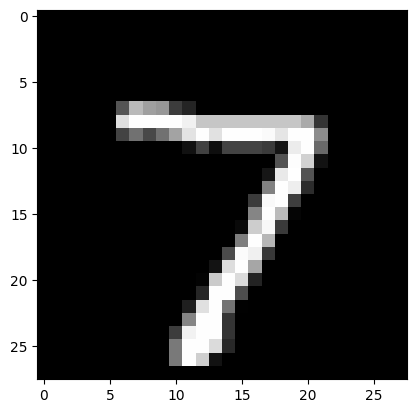

In [ ]:
plt.imshow(np.load('output/image_0_perturb_0.npy'), cmap='gray', vmin=0, vmax=1)

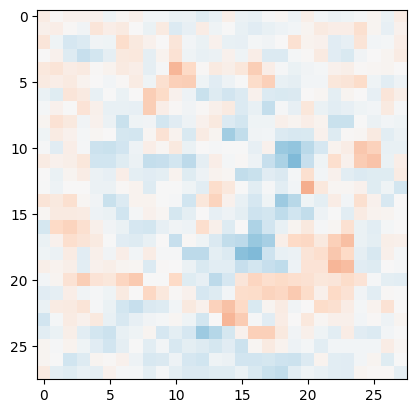

In [ ]:
plt.imshow(np.load('output/ours_0_perturb_0.npy'), cmap='RdBu', vmin=-0.1, vmax=0.1)